In [1]:
from IPython.core.interactiveshell import InteractiveShell 
import datetime as dt 
from datetime import timedelta
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pyplot as plt #for visualization
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns 
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline    
sns.set_theme(style="ticks", context="talk", palette="flare")   
plt.style.use("dark_background")
import altair as alt

#ARIMA essentials
from scipy import stats 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
int_df = pd.read_csv('fed-funds-rate-historical-chart.csv')
int_df = int_df.copy() 

qqq_origin = pd.read_csv('QQQ.csv')
qqq = qqq_origin.copy() 

In [3]:
int_df.head(20)

,Macrotrends Data Download,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,Federal Funds Rate - 62 Year Historical Chart,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,DISCLAIMER AND TERMS OF USE: HISTORICAL DATA I...,NaN,NaN,NaN,NaN
4,FOR INFORMATIONAL PURPOSES - NOT FOR TRADING P...,NaN,NaN,NaN,NaN
5,NEITHER MACROTRENDS LLC NOR ANY OF OUR INFORMA...,NaN,NaN,NaN,NaN
6,FOR ANY DAMAGES RELATING TO YOUR USE OF THE DA...,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [4]:
int_df.columns

Index(['Macrotrends Data Download', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4'],
      dtype='object')

In [5]:
int_df = int_df.iloc[15:]
int_df = int_df.drop(columns=['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'])
int_df = int_df.rename(columns={'Macrotrends Data Download': 'Date', 'Unnamed: 1': 'Interest Rate(%)'})
int_df.head()

,Date,Interest Rate(%)
15,1/7/1954,1.13
16,2/7/1954,1.25
17,3/7/1954,1.25
18,4/7/1954,1.25
19,5/7/1954,0.88


In [6]:
int_df['Date'] = pd.to_datetime(int_df['Date']) 
int_df = int_df[int_df['Date'].dt.day == 1]
int_df.head(10)

C:\Users\marcu\AppData\Local\Temp\ipykernel_23212\2555971359.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  int_df['Date'] = pd.to_datetime(int_df['Date'])


,Date,Interest Rate(%)
199,1955-01-01,1.44
200,1955-02-01,1.44
201,1955-03-01,1.44
202,1955-04-01,1.25
203,1955-05-01,1
204,1955-06-01,1.25
205,1955-07-01,1.44
206,1955-08-01,1.44
207,1955-09-01,1.44
208,1955-10-01,1.44


In [7]:
mask = (int_df['Date'] >= '2003-02-01') & (int_df['Date'] <= '2023-03-01')
df = int_df.loc[mask]
df['Date'] = df['Date'].apply(lambda d: str(d.day) + '/' + str(d.month) + '/' + str(d.year))
df.set_index('Date')
df.sample(frac=0.05, replace=True, random_state=1)

C:\Users\marcu\AppData\Local\Temp\ipykernel_23212\136702587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(lambda d: str(d.day) + '/' + str(d.month) + '/' + str(d.year))


,Date,Interest Rate(%)
18829,1/3/2006,4.34
21758,1/10/2014,0.07
19924,1/2/2009,0.08
21755,1/7/2014,0.07
23761,1/9/2020,1.55
21751,1/3/2014,0.08
19931,1/9/2009,0.09
23507,1/4/2019,2.4
22115,1/2/2015,0.12
21394,1/11/2013,0.14


In [8]:
df = df.set_index('Date')
df.head()

,Interest Rate(%)
Date,
1/2/2003,1.3
1/3/2003,1.12
1/4/2003,1.12
1/5/2003,1.12
1/6/2003,1.22


In [9]:
qqq.head(3) 

,Date,Open,High,Low,Close,Adj Close,Volume,%(close),AVE %
0,1/2/2003,24.520000,25.370001,23.320000,25.160000,21.633905,1276622500,0.003577,0.011757
1,1/3/2003,25.270000,27.379999,23.540001,25.250000,21.711300,1670716200,0.087129,NaN
2,1/4/2003,25.440001,28.059999,25.250000,27.450001,23.602982,1411620800,0.085246,NaN


In [10]:
def exclude_rename_adjust(df): 
    exclude = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'AVE %']
    df = df.drop(columns = exclude) 
    df = df.set_index('Date')
    df = df.rename(columns = {"%(close)": "Price Movement(%)"}) # proper naming
    df['Price Movement(%)'] = df['Price Movement(%)'].apply(lambda x: x*100) # adjust for percentage
    return df

qqq = exclude_rename_adjust(qqq) 

In [11]:
qqq.head(3)

,Price Movement(%)
Date,
1/2/2003,0.357710
1/3/2003,8.712875
1/4/2003,8.524590


In [12]:
df_concat = pd.concat([qqq, df], axis=1)
df_concat.head(3)

,Price Movement(%),Interest Rate(%)
Date,,
1/2/2003,0.357710,1.3
1/3/2003,8.712875,1.12
1/4/2003,8.524590,1.12


In [13]:
df_concat = df_concat.reset_index()
df_concat = df_concat.drop(columns='Date')
df_concat = df_concat.set_index('Interest Rate(%)')
df_concat.head(10)

,Price Movement(%)
Interest Rate(%),
1.3,0.357710
1.12,8.712875
1.12,8.524590
1.12,0.537093
1.22,6.176955
1.2,5.000000
1.29,-2.905064
1.29,8.513270
1.25,0.568508


In [14]:
df_concat['Price Movement(%)'].min()

-100.0

In [15]:
df_concat[df_concat['Price Movement(%)']==-100]

,Price Movement(%)
Interest Rate(%),
NaN,-100.0


In [16]:
df_concat = df_concat.iloc[:-1:]
df_concat[df_concat['Price Movement(%)']==-100]

,Price Movement(%)
Interest Rate(%),


In [17]:
df_concat = df_concat.astype(np.float64) 
df_concat['Price Movement(%)'] = df_concat['Price Movement(%)'].astype(np.float64)
df_concat.index = df_concat.index.astype(np.float64)

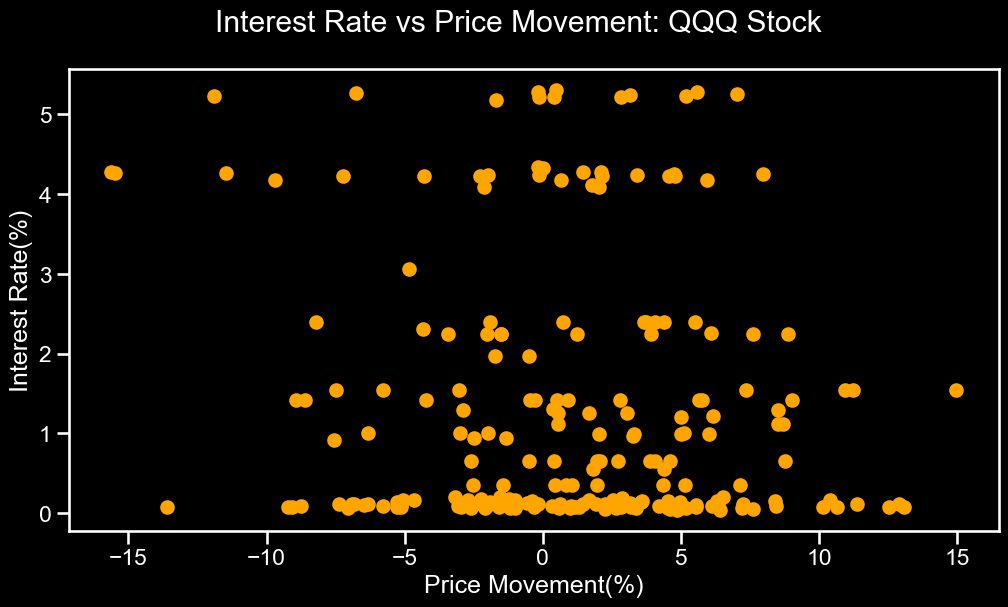

In [18]:
plt.figure(figsize=(12,6)) 
plt.scatter(df_concat['Price Movement(%)'], df_concat.index, color='orange')
plt.ylabel('Interest Rate(%)')
plt.xlabel('Price Movement(%)')
plt.suptitle('Interest Rate vs Price Movement: QQQ Stock')
plt.show()

Stationarity Check - ADCF Test

In [19]:
# ADF Test
result = adfuller(df_concat.values, autolag='AIC')

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -15.524170
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Reject Ho - Time Series is Stationary


c:\Users\marcu\OneDrive\Desktop\JPM Hackathon\.venv\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1500x700 with 0 Axes>

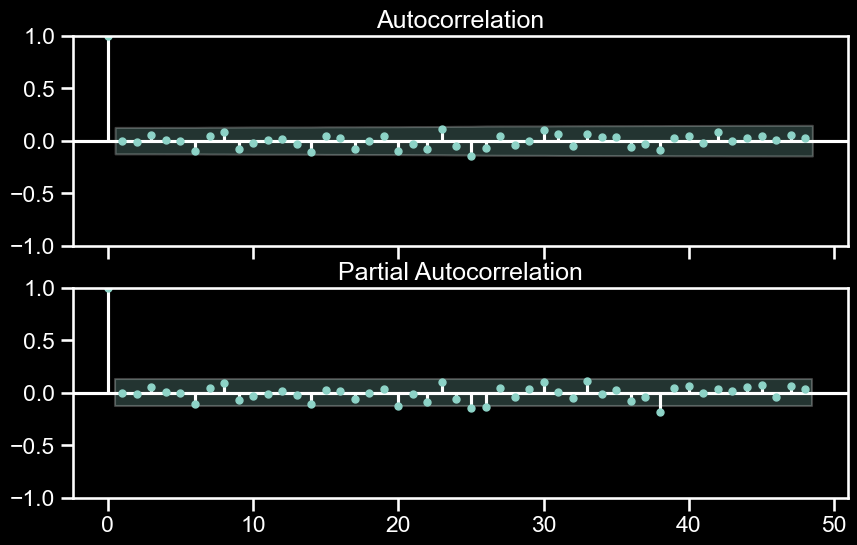

In [20]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_concat['Price Movement(%)'].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_concat['Price Movement(%)'].values.squeeze(), lags=48, ax=ax)
plt.show()

Approximation of Parameters

In [21]:
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_concat['Price Movement(%)'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [22]:
print("Best Models")
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

Best Models
      parameters          aic
7   (0, 1, 0, 1)  1461.532932
31  (1, 2, 0, 1)  1462.393414
9   (0, 1, 1, 1)  1463.240369
25  (1, 1, 0, 1)  1463.489460
13  (0, 2, 0, 1)  1463.490366
                                     SARIMAX Results                                      
Dep. Variable:                  Price Movement(%)   No. Observations:                  242
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -727.766
Date:                            Wed, 22 Mar 2023   AIC                           1461.533
Time:                                    13:26:18   BIC                           1471.834
Sample:                                         0   HQIC                          1465.689
                                            - 242                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-

Dickey–Fuller test:: p=0.000000


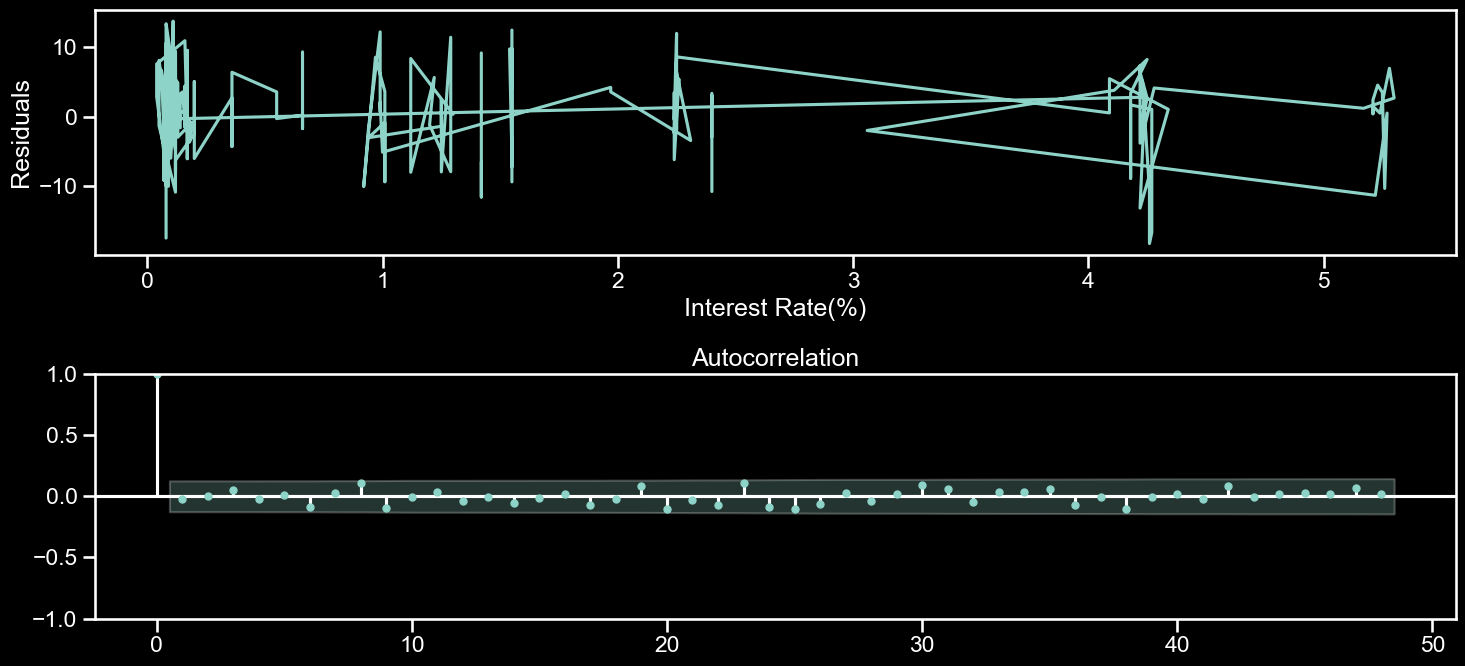

In [23]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

plt.tight_layout()
plt.show()

In [24]:
df_concat_test = df_concat.copy()
df_concat_test = df_concat_test.reset_index()
best_model = best_model.predict().to_frame().reset_index()['predicted_mean']
df_concat_test['forecast'] = best_model

<Figure size 1200x600 with 0 Axes>

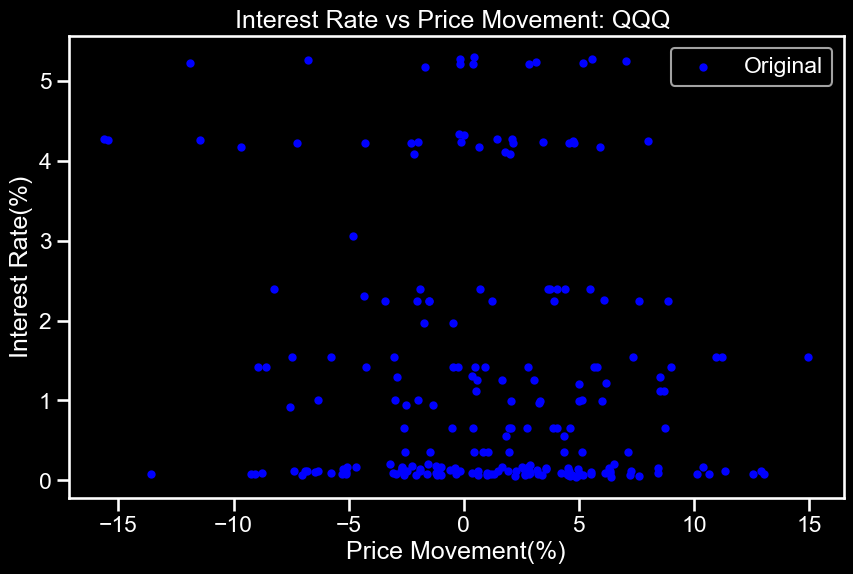

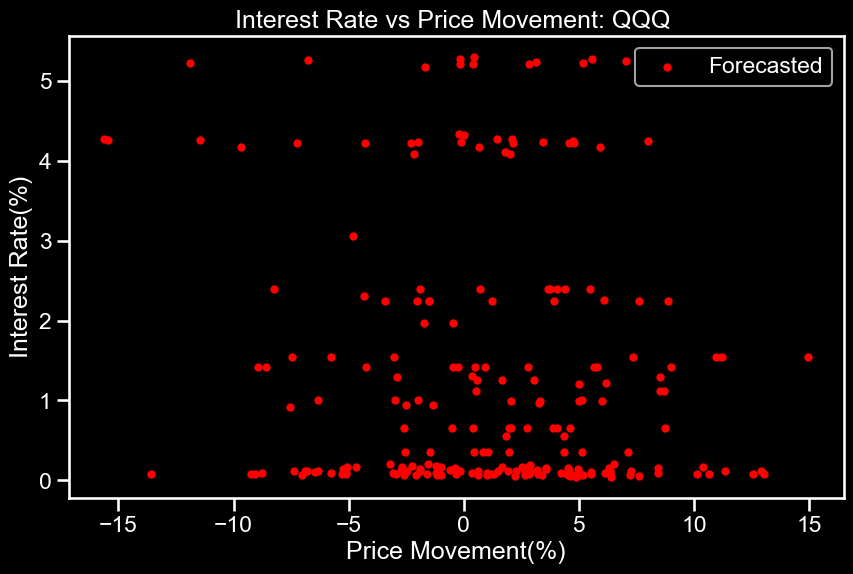

In [25]:
alpha = 1
plt.figure(figsize=(12,6))
df_concat_test.plot(x='Price Movement(%)', y='Interest Rate(%)', kind='scatter', color='blue', alpha=alpha, label = 'Original')
plt.title('Interest Rate vs Price Movement: QQQ ')
df_concat_test.plot(x='Price Movement(%)', y='Interest Rate(%)', kind='scatter', color='red', alpha=alpha, label='Forecasted')
plt.legend()
plt.title('Interest Rate vs Price Movement: QQQ ')
plt.ylabel('Interest Rate(%)')
plt.xlabel('Price Movement(%)')
plt.show()